In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import files  # Import the files module for Colab

# --- 1. Upload Data ---
# This part is specific to Google Colab.
# Run this cell, and a button will appear to upload your files.
# You MUST upload 'train.csv', 'test.csv', and 'sample_submission.csv'
print("Please upload your three files: train.csv, test.csv, and sample_submission.csv")
uploaded = files.upload()

# Check if files were uploaded
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

print("\n--- Data upload complete. Starting script. ---")


# --- 2. Load Data ---
# We load the files directly from the local Colab environment
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    sample_submission_df = pd.read_csv("sample_submission.csv")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("One or more files (train.csv, test.csv, sample_submission.csv) were not found.")
    print("Please make sure you uploaded all three files correctly and re-run the cell.")
    # Stop the script if files are missing
    raise

print("\n--- Successfully loaded all CSV files. ---")


# --- 3. Quick Data Check (Optional but good practice) ---
print("\n--- Training Data Info ---")
train_df.info()


# --- 4. Prepare Data for Modeling ---
TARGET = 'accident_risk'

# Define the features (all columns EXCEPT id and the target)
features = [col for col in train_df.columns if col not in ['id', TARGET]]

# Create our X (features) and y (target)
X = train_df[features]
y = train_df[TARGET]

# Get the features from the test set
test_features = test_df[features]

print(f"\nTraining with {len(features)} features.")


# --- 5. Train and Validate the Model ---
# We split the data to check our model's performance locally
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")

# Define the LightGBM model
model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31
)

# Train the model
print("\n--- Starting model training (with validation) ---")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100)] # Stop if validation score doesn't improve
)

# Evaluate the model
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\n--- Validation RMSE: {rmse} ---")
print("(This is an estimate of your competition score. Lower is better.)")


# --- 6. Create Final Submission File ---
# Now we re-train the model on ALL the training data
best_iteration = model.best_iteration_ if model.best_iteration_ else 1000

final_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=best_iteration,
    learning_rate=0.05,
    num_leaves=31
)

print("\n--- Starting final model training on all data ---")
final_model.fit(X, y)
print("--- Final model training finished ---")

# Make predictions on the official test set
test_predictions = final_model.predict(test_features)

# Safety Check: Clip predictions to be between 0 and 1
test_predictions = np.clip(test_predictions, 0, 1)

# Create the submission file
submission_df = sample_submission_df.copy()
submission_df['accident_risk'] = test_predictions

# Save the file to the Colab environment
submission_df.to_csv('submission.csv', index=False)

print("\n--- Submission file created successfully! ---")
print(submission_df.head())


# --- 7. Download the Submission File ---
print("\nDownloading submission.csv to your computer...")
files.download('submission.csv')

Please upload your three files: train.csv, test.csv, and sample_submission.csv


Saving train.csv to train (3).csv
Saving test.csv to test (3).csv
Saving sample_submission.csv to sample_submission (3).csv
User uploaded file "train (3).csv" with length 37936892 bytes
User uploaded file "test (3).csv" with length 11835465 bytes
User uploaded file "sample_submission (3).csv" with length 2243622 bytes

--- Data upload complete. Starting script. ---

--- Successfully loaded all CSV files. ---

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather     

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: road_type: object, lighting: object, weather: object, time_of_day: object

In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import files  # Import the files module for Colab

# --- 1. Upload Data ---
# Run this cell, and a button will appear to upload your files.
# You MUST upload 'train.csv', 'test.csv', and 'sample_submission.csv'
print("Please upload your three files: train.csv, test.csv, and sample_submission.csv")
uploaded = files.upload()

# Check if files were uploaded
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

print("\n--- Data upload complete. Starting script. ---")


# --- 2. Load Data ---
# We load the files directly from the local Colab environment
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    sample_submission_df = pd.read_csv("sample_submission.csv")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("One or more files (train.csv, test.csv, sample_submission.csv) were not found.")
    print("Please make sure you uploaded all three files correctly and re-run the cell.")
    # Stop the script if files are missing
    raise

print("\n--- Successfully loaded all CSV files. ---")


# --- 3. FIX: Convert Text Columns to 'category' ---
# This is the new step to fix the error you saw.
# LightGBM cannot handle 'object' (text) columns directly.
# We convert them to a 'category' data type, which it understands.

# Find all columns that are of 'object' type (text)
categorical_features = train_df.select_dtypes(include=['object']).columns

print(f"\nFound text (categorical) features: {list(categorical_features)}")

# Convert these columns to 'category' dtype in both train and test sets
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

print("--- Successfully converted text columns to 'category' dtype. ---")
print("\nNew training data info (notice 'category' dtypes):")
train_df.info() # Show new dtypes


# --- 4. Prepare Data for Modeling ---
TARGET = 'accident_risk'

# Define the features (all columns EXCEPT id and the target)
features = [col for col in train_df.columns if col not in ['id', TARGET]]

# Create our X (features) and y (target)
X = train_df[features]
y = train_df[TARGET]

# Get the features from the test set
test_features = test_df[features]

print(f"\nTraining with {len(features)} features.")


# --- 5. Train and Validate the Model ---
# We split the data to check our model's performance locally
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")

# Define the LightGBM model
model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31
)

# Train the model
print("\n--- Starting model training (with validation) ---")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100)] # Stop if validation score doesn't improve
)

# Evaluate the model
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\n--- Validation RMSE: {rmse} ---")
print("(This is an estimate of your competition score. Lower is better.)")


# --- 6. Create Final Submission File ---
# Now we re-train the model on ALL the training data
best_iteration = model.best_iteration_ if model.best_iteration_ else 1000

final_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=best_iteration,
    learning_rate=0.05,
    num_leaves=31
)

print("\n--- Starting final model training on all data ---")
# We use .astype('category') on X and test_features again just to be safe
# This ensures the final model also sees the correct dtypes
for col in categorical_features:
    X[col] = X[col].astype('category')
    test_features[col] = test_features[col].astype('category')

final_model.fit(X, y)
print("--- Final model training finished ---")

# Make predictions on the official test set
test_predictions = final_model.predict(test_features)

# Safety Check: Clip predictions to be between 0 and 1
test_predictions = np.clip(test_predictions, 0, 1)

# Create the submission file
submission_df = sample_submission_df.copy()
submission_df['accident_risk'] = test_predictions

# Save the file to the Colab environment
submission_df.to_csv('submission.csv', index=False)

print("\n--- Submission file created successfully! ---")
print(submission_df.head())


# --- 7. Download the Submission File ---
print("\nDownloading submission.csv to your computer...")
files.download('submission.csv')

Please upload your three files: train.csv, test.csv, and sample_submission.csv


Saving train.csv to train (4).csv
Saving test.csv to test (4).csv
Saving sample_submission.csv to sample_submission (4).csv
User uploaded file "train (4).csv" with length 37936892 bytes
User uploaded file "test (4).csv" with length 11835465 bytes
User uploaded file "sample_submission (4).csv" with length 2243622 bytes

--- Data upload complete. Starting script. ---

--- Successfully loaded all CSV files. ---

Found text (categorical) features: ['road_type', 'lighting', 'weather', 'time_of_day']
--- Successfully converted text columns to 'category' dtype. ---

New training data info (notice 'category' dtypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int64   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int64 

/tmp/ipython-input-1874848879.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/tmp/ipython-input-1874848879.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[col] = test_features[col].astype('category')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 12
[LightGBM] [Info] Start training from score 0.352377
--- Final model training finished ---

--- Submission file created successfully! ---
       id  accident_risk
0  517754       0.291244
1  517755       0.123907
2  517756       0.183287
3  517757       0.312581
4  517758       0.406266



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:

# --- 6. Create Final Submission File ---
# Now we re-train the model on ALL the training data
best_iteration = model.best_iteration_ if model.best_iteration_ else 1000

final_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=best_iteration,
    learning_rate=0.05,
    num_leaves=31
)

print("\n--- Starting final model training on all data ---")
# We use .astype('category') on X and test_features again just to be safe
# This ensures the final model also sees the correct dtypes
for col in categorical_features:
    X[col] = X[col].astype('category')
    test_features[col] = test_features[col].astype('category')

final_model.fit(X, y)
print("--- Final model training finished ---")

# Make predictions on the official test set
test_predictions = final_model.predict(test_features)

# Safety Check: Clip predictions to be between 0 and 1
test_predictions = np.clip(test_predictions, 0, 1)

# Create the submission file
submission_df = sample_submission_df.copy()
submission_df['accident_risk'] = test_predictions

# Save the file to the Colab environment
submission_df.to_csv('submission.csv', index=False)

print("\n--- Submission file created successfully! ---")
print(submission_df.head())


# --- 7. Download the Submission File ---
print("\nDownloading submission.csv to your computer...")
files.download('submission.csv')


--- Starting final model training on all data ---


/tmp/ipython-input-2634060206.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/tmp/ipython-input-2634060206.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[col] = test_features[col].astype('category')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 12
[LightGBM] [Info] Start training from score 0.352377
--- Final model training finished ---

--- Submission file created successfully! ---
       id  accident_risk
0  517754       0.291244
1  517755       0.123907
2  517756       0.183287
3  517757       0.312581
4  517758       0.406266



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

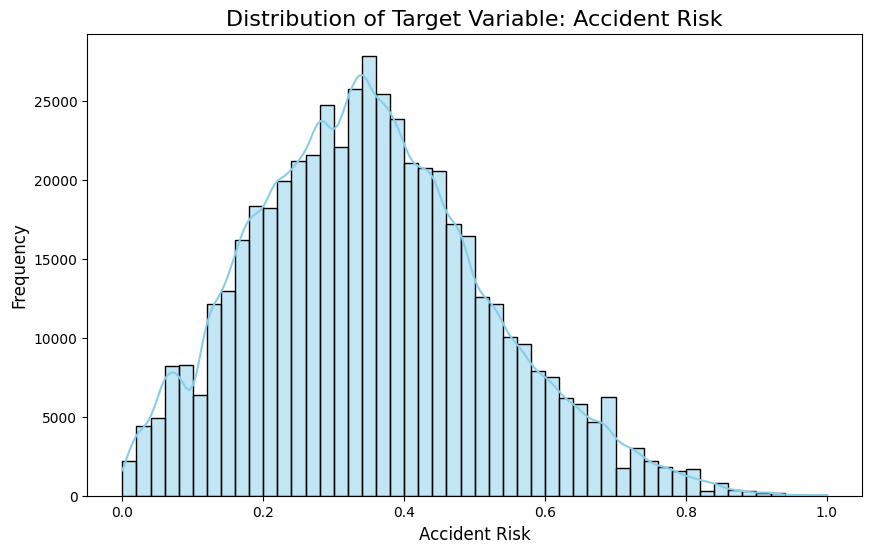

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'train_df' is already loaded and contains the necessary columns

# NOTE: The 'plt.close()' and 'plt.savefig()' lines have been removed to display plots inline.

## Plot 1: Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['accident_risk'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Target Variable: Accident Risk', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show() # Use plt.show() to explicitly display the figure if not in an interactive environment



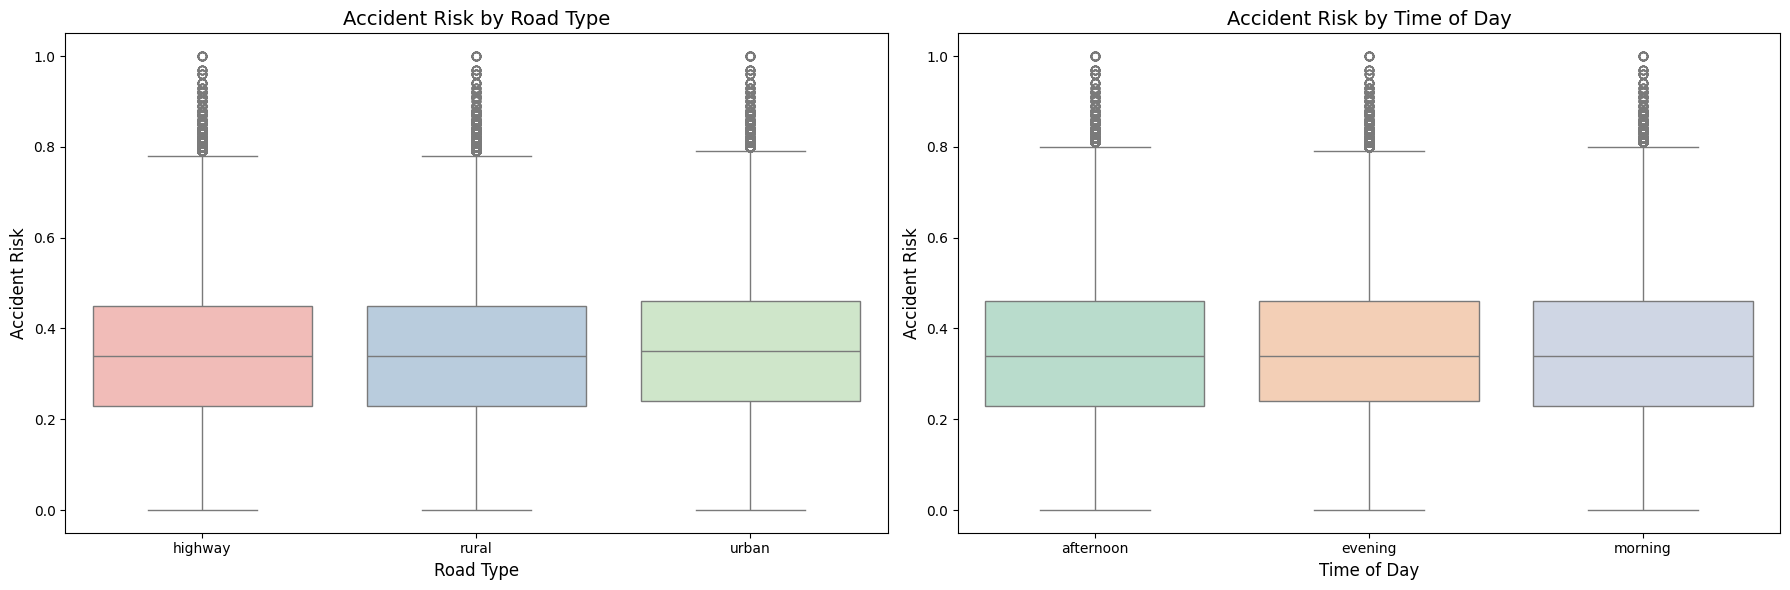

In [9]:

## Plot 2: Relationship with Categorical Features (road_type and time_of_day)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# MODIFIED: Added hue='road_type' and legend=False
sns.boxplot(x='road_type', y='accident_risk', data=train_df, ax=axes[0], palette='Pastel1', hue='road_type', legend=False)
axes[0].set_title('Accident Risk by Road Type', fontsize=14)
axes[0].set_xlabel('Road Type', fontsize=12)
axes[0].set_ylabel('Accident Risk', fontsize=12)

# MODIFIED: Added hue='time_of_day' and legend=False
sns.boxplot(x='time_of_day', y='accident_risk', data=train_df, ax=axes[1], palette='Pastel2', hue='time_of_day', legend=False)
axes[1].set_title('Accident Risk by Time of Day', fontsize=14)
axes[1].set_xlabel('Time of Day', fontsize=12)
axes[1].set_ylabel('Accident Risk', fontsize=12)

plt.tight_layout()
plt.show()



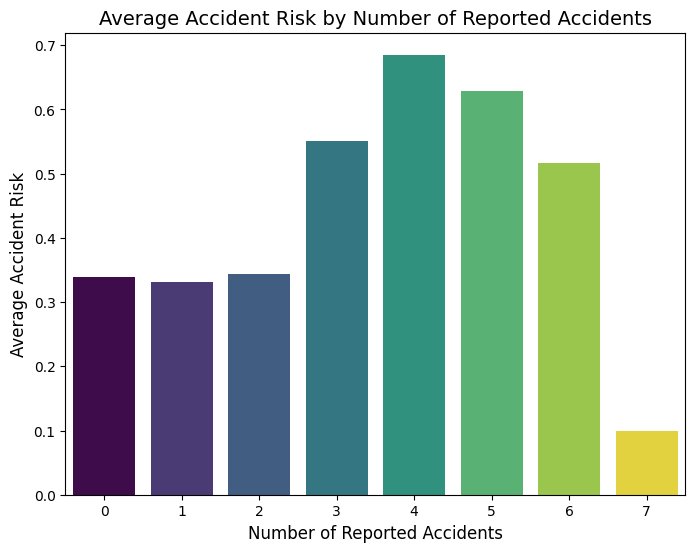

In [10]:
# Plot 3: Relationship with a Numerical Feature (num_reported_accidents)
temp_df = train_df.groupby('num_reported_accidents')['accident_risk'].mean().reset_index()

plt.figure(figsize=(8, 6))
# MODIFIED line to include hue and legend=False
sns.barplot(x='num_reported_accidents', y='accident_risk', data=temp_df, palette='viridis', hue='num_reported_accidents', legend=False)
plt.title('Average Accident Risk by Number of Reported Accidents', fontsize=14)
plt.xlabel('Number of Reported Accidents', fontsize=12)
plt.ylabel('Average Accident Risk', fontsize=12)
plt.show()


In [11]:
# Separate target variable and IDs
y_train = train_df['accident_risk']
train_ids = train_df['id']
test_ids = test_df['id']

# Drop the id and target columns from training set, and id from test set
X_train = train_df.drop(['id', 'accident_risk'], axis=1)
X_test = test_df.drop('id', axis=1)

# Concatenate train and test data for unified preprocessing
combined_df = pd.concat([X_train, X_test], ignore_index=True)

# Convert boolean columns to integer (0 or 1)
bool_cols = combined_df.select_dtypes(include='bool').columns
for col in bool_cols:
    combined_df[col] = combined_df[col].astype(int)

# Identify nominal categorical columns
nominal_cols = combined_df.select_dtypes(include='object').columns

# Apply One-Hot Encoding
combined_df_encoded = pd.get_dummies(combined_df, columns=nominal_cols, drop_first=False)

# Split back into training and test sets
X_train_processed = combined_df_encoded.iloc[:len(X_train)]
X_test_processed = combined_df_encoded.iloc[len(X_train):]

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

Processed training shape: (517754, 12)
Processed test shape: (172585, 12)
